In [1]:
using Revise, ReachabilityAnalysis, SparseArrays, ModelingToolkit

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Array{var"#s49",1} where var"#s49"<:Operation}, Tuple{Array{var"#s48",1} where var"#s48"<:Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Array{var"#s49",1} where var"#s49"<:Operation}, Tuple{Array{var"#s48",1} where var"#s48"<:Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227


In [2]:
const var = @variables x[1:9] t

function platoon_connected(; deterministic_switching::Bool=true,
                             c1=5.0)  # clock constraints
    n = 9 + 1

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c1, var)
    else
        invariant = Universe(n)
    end

    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

function platoon_disconnected(; deterministic_switching::Bool=true,
                                c2=5.0)  # clock constraints
    n = 10 # 9 dimensions + time

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, 0, 0, 0, 0, 0, 0, 0]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0, 0, 0,  1.1936, 3.6258, -3.2396, 0, 0, 0, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c2, var)
    else
        invariant = Universe(n)
    end

    #acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

function platoon(; deterministic_switching::Bool=true,
                   c1=5.0,  # clock constraints
                   c2=5.0,  # clock constraints
                   tb=10.0,  # lower bound for loss of communication
                   tc=20.0, tr=20.0) # upper bound for loss of communication (tc) and reset time (tr)

    #three variables for each vehicle, (ei, d(et)/dt, ai) for
    #(spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    #transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    #modes
    mode1 = platoon_connected(deterministic_switching=deterministic_switching, c1=c1)
    mode2 = platoon_disconnected(deterministic_switching=deterministic_switching, c2=c2)
    modes = [mode1, mode2]

    #common reset
    reset = Dict(n => 0.)

    #transition l1 -> l2
    if deterministic_switching
        guard = Hyperplane(t == c1, var)
    else
        guard = HPolyhedron([tb <= t, t <= tc], var)
    end
    t1 = ConstrainedResetMap(n, guard, reset)

    #transition l2 -> l1
    if deterministic_switching
        guard = Hyperplane(t == c2, var)
    else
        guard = HalfSpace(t <= tr, var)
    end
    t2 = ConstrainedResetMap(n, guard, reset)
    resetmaps = [t1, t2]

    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    #initial condition is at the orgin in mode 1
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]

    return IVP(H, initial_condition)
end

platoon (generic function with 1 method)

In [3]:
platoon_connected()

ConstrainedAffineControlContinuousSystem{Float64,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}([0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.7132 3.573 … -3.1356 0.0; 0.0 0.0 … 0.0 0.0], 
  [2, 1]  =  1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 5.0), Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-4.0], [5.0]))

## Estudio de la parte puramente continua (connected)

Solucion del problema continuo:

In [ ]:
# problema puramente continuo
ivp1 = IVP(platoon_connected(), BallInf(zeros(10), 0.0));

In [ ]:
# resuelvo el problema puramente continuo
@time sol1 = solve(ivp1, tspan=(0.0, 20.0), alg=GLGM06(δ=0.03));

In [ ]:
# prueba con static arrays
using StaticArrays, BenchmarkTools

@time sol1 = solve(ivp1, tspan=(0.0, 20.0), alg=GLGM06(δ=0.03, static=true, dim=10, max_order=1, ngens=10));

Ahora hacemos la transicion "a mano":

Resultados:

```julia
@btime sol1 = solve($ivp1, tspan=(0.0, 20.0), alg=GLGM06(δ=0.03, static=true, dim=10, max_order=1, ngens=10));

  959.459 μs (3458 allocations: 2.30 MiB)

@btime sol1 = solve($ivp1, tspan=(0.0, 20.0), alg=GLGM06(δ=0.03));
  2.310 ms (5978 allocations: 4.44 MiB)

```

Observaciones:

- hacer tablita con `@btime` de cada algoritmo
- GLGM06 con arrays regulares
- GLGM06 con static arrays
- BOX (sin static)
- BOX (con static no porque no esta implementado, creo)
- TMJets

#### Try with TMJets

In [ ]:
plac = platoon_connected()
const Aext = ReachabilityAnalysis.add_dimension(plac.A, 1)
const bext = vcat(plac.c, 0.0)

# compute Ax + b and store the result in v
function mymulb!(v, A, x, b)
    @inbounds for ind = 1:length(v)
        v[ind] = b[ind]
        for jind = 1:length(x)
            v[ind] += A[ind, jind] * x[jind]
        end
    end
    return nothing
end

# z contains 9 state variables, 1 variable for time, and 1 variable for the non-deterministic input 
@taylorize function _platoon_connected!(dz, z, p, t)
    
    x1, x2, x3, x4, x5, x6, x7, x8, x9, t′, u = z

    # x' = Ax + Bu + c, with Bu a state variable applided in the second coefficient
    # c1 = 5.0
    z′ = Vector{eltype(z)}(undef, 11)
    
    z′[1] = one(x1)
    z′[2] = one(x1)
    z′[3] = one(x1)
    z′[4] = one(x1)
    z′[5] = one(x1)
    z′[6] = one(x1)
    z′[7] = one(x1)
    z′[8] = one(x1)
    z′[9] = one(x1)
    z′[10] = one(x1)
    z′[11] = one(x1)
    
    #z′[2] = z′[2] + u
    #mymulb!(z′, Aext, z, bext)
    dz[1] = z′[1]
    dz[2] = z′[2]
    dz[3] = z′[3]
    dz[4] = z′[4]
    dz[5] = z′[5]
    dz[6] = z′[6]
    dz[7] = z′[7]
    dz[8] = z′[8]
    dz[9] = z′[9]
    dz[10] = z′[10]
    dz[11] = z′[11]
end

In [ ]:
U0 = plac.U
X0 = BallInf(zeros(10), 0.0)
invariant = plac.X × Universe(1)
ivp2 = @ivp(z' = _platoon_connected!(z), dim=11, z(0) ∈ X0 × U0, z ∈ invariant);
@time sol1 = solve(ivp2, tspan=(0.0, 20.0), alg=TMJets());

- dejamos porque sigue dando problemas....

-----

### Estudiar la 1er transicion.

In [ ]:
@time sol1 = solve(ivp1, tspan=(0.0, 20.0), alg=GLGM06(δ=0.03));

In [ ]:
using Plots

In [ ]:
guard = Hyperplane(t == 5.0, var)

In [ ]:
plot(sol1,vars=(0, 1), xlab="t", ylab="x1")

In [ ]:
plot(sol1,vars=(0, 4), xlab="t", ylab="x4")

In [ ]:
plot(sol1,vars=(0, 7), xlab="t", ylab="x7")

In [ ]:
plot(sol1,vars=(0, 10), xlab="t", ylab="time variable")

In [ ]:
source_invariant = stateset(ivp1) # t <= 5.0

In [ ]:
# la condicion inicial va a ser lo que resulte del apply
ivp2 = IVP(platoon_disconnected(), BallInf(zeros(10), 0.0));
target_invariant = stateset(ivp2) # t <= 5

In [ ]:
prob_PLAD01_BND30 = platoon(; deterministic_switching=true);

In [ ]:
L = prob_PLAD01_BND30.s.resetmaps[1] # y = Rx + c

R = ReachabilityAnalysis._state_matrix(L)
W = ReachabilityAnalysis._affine_term(L);

In [ ]:
W

post_d(X) = (R(X ∩ G ∩ I⁻) ⊕ W) ∩ I⁺

In [ ]:
Z

In [ ]:
I⁺

In [ ]:
Z = set(sol1[end-1])
I⁺ = tr.I⁺
@which Z ⊆ I⁺

In [ ]:
@btime LazySets._issubset_constraints_list($Z, $I⁺)

In [ ]:
@btime $Z ⊆ $I⁺

In [ ]:
guard # t == 5
I⁻ # t <= 5

# la interseccion da t == 5

In [ ]:
intersection(source_invariant, guard)

Dado un hyperplane $G : \{ x \in \mathbb{R}^n : a_G^T x = b_G\}$

Dado un halfspace $H : \{ x \in \mathbb{R}^n : a_H^T x \leq b_H\}$

$a_G = α a_H$

$$
\alpha a_H^T x = b_G
$$

$a_H^T x = b_G  / \alpha$

$b_G /\alpha \leq b_H$

In [ ]:
using LazySets.Arrays

# given a hyperplane G and a half-space H,
# return true iff G ∩ H = G
function _intersection_is_hyperplane(G::Hyperplane, H::HalfSpace)
    aG, bG = G.a, G.b
    aH, bH = H.a, H.b

    # check aG = α * aH with α > 0
    isprop, α = samedir(aG, aH)
    if isprop
        return bG / α ≤ bH
    end
    
    # check aG = -α * aH with α > 0
    isprop, α = samedir(-aG, aH)
    if isprop
        return bG / (-α) ≤ bH
    end

    return false
end

$$
H : a_1 x + a_2 y \leq b
$$

$$
G : 2a_1 x + 2a_2 y = b
$$

In [ ]:
H = rand(HalfSpace)
G = Hyperplane(2.0 * H.a, H.b)

@show _intersection_is_hyperplane(G, H)

plot(H)
plot!(G, lw=2.0)

In [ ]:
@btime _intersection_is_hyperplane($G, $H)

In [ ]:
# naive implementation
@btime isequivalent(intersection($G, $H), $G)

In [ ]:
# TODO review, generalize R and W types ?
using LinearAlgebra

function _apply(tr::DiscreteTransition{<:Diagonal{N}, <:Singleton{N}, GT, IT⁻, IT⁺},
                X::Zonotope{N}, # depende tambien del clustering
                method::TemplateHullIntersection) where {N, GT<:Hyperplane{N},
                                                            IT⁻<:HalfSpace{N},
                                                            IT⁺<:HalfSpace{N}}
    Y = overapproximate(X ∩ tr.G, method.dirs)
    Z = overapproximate(Y, Zonotope, algorithm="cpa")

    #=
    success, aux = _intersection(tr.G, tr.I⁻, method)
    !success && return EmptySet(dim(X))
    P = HPolyhedron(aux)
    for x in
        addconstraint!(P, x)
    end
    Y = _apply_reset(R, P, W, method)

    success, out = _intersection(Y, tr.I⁺, method)
    return success ? HPolytope(out) : EmptySet(dim(X))
    =#
end

In [ ]:
tr = DiscreteTransition(R, W, guard, source_invariant, target_invariant)

In [ ]:
X = set(sol1[end])

_apply(tr, X, TemplateHullIntersection())

In [ ]:
plot(sol1[end-10:end],vars=(10, 1), xlab="t", ylab="x1")

#plot(Projection(stateset(ivp1), (10, 1))) # RARO ... es unbounded
#AssertionError: package 'Polyhedra' not loaded (it is required for executing `linear_map with elimination`)

plot!(Hyperplane([1.0, 0.0], 5.0), lw=2.0)

In [ ]:
#=
isdisjoint(sol1, rand(Hyperplane, dim=10))

MethodError: no method matching length(::Hyperplane{Float64,Array{Float64,1}})
Closest candidates are:
  length(!Matched::Base.MethodList) at reflection.jl:852
  length(!Matched::Combinatorics.IntegerPartitions) at /home/mforets/.julia/packages/Combinatorics/Udg6X/src/partitions.jl:17
  length(!Matched::RecipesPipeline.DefaultsDict) at /home/mforets/.julia/packages/RecipesPipeline/5RD7m/src/utils.jl:34

=#

In [ ]:
aux = [isdisjoint(set(R), guard) for R in sol1]
aux[end-10:end]

In [ ]:
X = sol1[end]

In [ ]:
plot(X,vars=(3, 4))

### Estudiar las otras transiciones.

## Estudio de todo el sistema hibrido

In [ ]:
#=
alg = GLGM06(δ=0.03);
@time sol = solve(prob_PLAD01_BND30,
                  alg=alg,
                  clustering_method=ZonotopeClustering(),
                  intersect_source_invariant=false,
                  tspan = (0.0 .. 20.0));
=#

In [ ]:
ReachabilityAnalysis.Template

In [7]:
octdirs = OctDirections(10);
prob_PLAD01_BND30 = platoon()

InitialValueProblem{HybridSystem{LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}},ConstrainedAffineControlContinuousSystem{Float64,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},ConstrainedResetMap{Float64,Hyperplane{Float64,Array{Float64,1}}},AutonomousSwitching,Array{ConstrainedAffineControlContinuousSystem{Float64,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}},1},Array{ConstrainedResetMap{Float64,Hyperplane{Float64,Array{Float64,1}}},1},Array{AutonomousSwitching,1}},Array{Tuple{Int64,BallInf{Float64,Array{Float64,1}}},1}}(Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({2, 2} directed simple Int64 graph, Dict{LightGraphs.

In [14]:
using Optim, Plots

In [34]:
LazySets.set_rtol(Float64, 1e-15)
LazySets.set_ztol(Float64, 1e-15)
LazySets.set_atol(Float64, 1e-15)

1.0e-15

In [112]:
#alg = GLGM06(δ=0.00005); # doesn't take the jump...??

alg = GLGM06(δ=0.01, max_order=100);

@time sol = solve(prob_PLAD01_BND30,
                  alg=alg,
                  clustering_method=ZonotopeClustering(),
                  intersect_source_invariant=false,
                  intersection_method=ReachabilityAnalysis.TemplateHullIntersectionZonotope(octdirs),
                  tspan = (0.0 .. 20.0));

index of sets that take the jump: [500, 501]
index of sets that take the jump: [500, 501]
index of sets that take the jump: [500, 501]
index of sets that take the jump: [500, 501]
index of sets that take the jump: Int64[]
  2.323609 seconds (6.23 M allocations: 1.005 GiB, 6.33% gc time)


In [113]:
-ρ(sparsevec([1], [-1.0], 10), sol)

-33.08588654881664

In [114]:
using Polyhedra, QHull

┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Union{HRepresentation{N}, Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Union{HRepresentation{N}, Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{Union{HPolyhedron{N,VN} where VN<:AbstractArray{N,1}, HPolytope{N,VN} where VN<:AbstractArray{N,1}}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{VPolytope{N,VN} where VN<:AbstractArray{N,1}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227


LoadError: ArgumentError: Package QHull not found in current path:
- Run `import Pkg; Pkg.add("QHull")` to install the QHull package.


In [115]:
import Pkg; Pkg.add("QHull")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [=======================>                 ]  

Fetching: [========================================>]  100.0 %

  Resolving package versions...
Updating `~/Projects/escritoire/2020/Project.toml`
  [a8468747] + QHull v0.2.1
Updating `~/Projects/escritoire/2020/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  [6e34b625] + Bzip2_jll v1.0.6+3
  [49dc2e85] + Calculus v0.5.1
  [523fee87] + CodecBzip2 v0.7.2
  [944b1d66] + CodecZlib v0.7.0
  [3da002f7] + ColorTypes v0.10.8
  [8f4d0f93] + Conda v1.4.1
  [53c48c17] + FixedPointNumbers v0.8.4
  [4d00f742] + GeometryTypes v0.8.3
  [cd3eb016] + HTTP v0.8.17
  [83e8ac13] + IniFile v0.5.0
  [682c06a0] + JSON v0.21.0
  [7d188eb4] + JSONSchema v0.3.1
  [4076af6c] + JuMP v0.21.3
  [b8f27783] + MathOptInterface v0.9.14
  [739be429] + MbedTLS v1.0.2
  [c8ffd9c3] + MbedTLS_jll v2.16.6+1
  [d8a4904e] + MutableArithmetics v0.2.10
  [69de0a69] + Parsers v1.0.10
  [67491407] + Polyhedra v0.6.5
  [438e738f] + PyCall v1.91.4
  [a8468747] + QHull v0.2.1
  [3bb67fe8] + TranscodingStreams v0.9.5
  [81def892] + VersionParsing v1.2.0
  [a5390f91] + ZipFile v0.9.2


### Results

```
alg = GLGM06(δ=0.01);
@time sol = solve(prob_PLAD01_BND30,
                  alg=alg,
                  clustering_method=ZonotopeClustering(),
                  intersect_source_invariant=false,
                  intersection_method=ReachabilityAnalysis.TemplateHullIntersectionZonotope(octdirs),
                  tspan = (0.0 .. 20.0));
```

we get

```julia
number of sets that take the jump: [500, 501]
number of sets that take the jump: [500, 501]
number of sets that take the jump: [500, 501]
number of sets that take the jump: [500, 501]
number of sets that take the jump: Int64[]
  2.072957 seconds (6.17 M allocations: 405.884 MiB, 6.39% gc time)
```

Computation of the `-ρ(sparsevec([1], [-1.0], 10), sol)`:

- `-36.761087008210495` using cpa alg for the clustering
- `-36.78171751307127` using "mean" method for convex hull of zonotopes
- `-36.76961411331021` using "join" method for convex hull of zonotopes 

- `alg = GLGM06(δ=0.005, max_order=800);` gives `-32.713816637449966`

- `alg = GLGM06(δ=0.01, max_order=100);` gives `-33.08588654881664` using zonotope CPA overapproximation of the discretized set using Forward approximation (lazy)

- `alg = GLGM06(δ=0.01, max_order=100);` gives `-41.15656143452868`
using hyperrectangular overapproximation of the discretized set using Forward approximation (lazy)

- we observe that smaller delta doesn't improve the precision

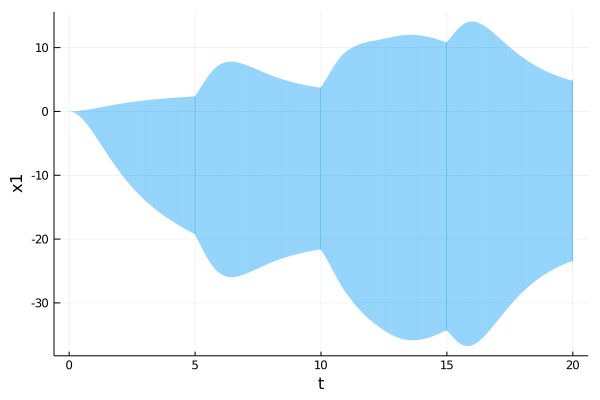

In [79]:
plot(sol,vars=(0, 1), xlab="t", ylab="x1", lw=0.0, fmt=:png)

In [53]:
#plot(sol,vars=(0, 1), xlab="t", ylab="x1", lw=0.0)

In [ ]:
function dmin_specification(sol, dmin)
    return (-ρ(sparsevec([1], [-1.0], 10), sol) > dmin) &&
           (-ρ(sparsevec([4], [-1.0], 10), sol) > dmin) &&
           (-ρ(sparsevec([7], [-1.0], 10), sol) > dmin)
end